Task 3: Forest Cover Type Classification

In this notebook, we will:
- Load and explore the Forest Cover Type dataset  
- Preprocess the data (handle categorical & continuous features)  
- Train and evaluate **Random Forest** and **XGBoost** models  
- Visualize **confusion matrices** and **feature importances**  
- Compare model performance  
- Perform hyperparameter tuning (bonus)

In [1]:
# 📦 Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Plotting style
sns.set(style="whitegrid", palette="muted", font_scale=1.2)


##  Load the Dataset
We load the `covtype.csv` file that contains cartographic and environmental features, along with the target variable `Cover_Type`.


In [2]:
# Load dataset
data_path = "/kaggle/input/forecast-cover-type-classification/covtype.csv"  # <-- Update path in Kaggle
df = pd.read_csv(data_path)

print("Shape of dataset:", df.shape)
df.head()


Shape of dataset: (581012, 55)


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


##  Data Exploration
Check missing values, basic statistics, and target distribution.


0 missing values in dataset


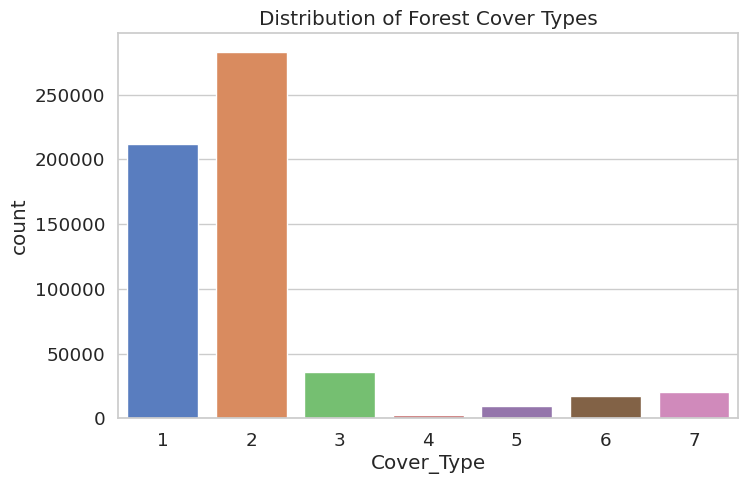

In [3]:
# Check for missing values
print(df.isnull().sum().sum(), "missing values in dataset")

# Target distribution
plt.figure(figsize=(8,5))
sns.countplot(x="Cover_Type", data=df)
plt.title("Distribution of Forest Cover Types")
plt.show()


##  Preprocessing
- Separate features (`X`) and target (`y`)  
- Ensure categorical features are handled (here: `Wilderness_Area` and `Soil_Type` are already one-hot encoded in UCI dataset format).  
- Train/test split.  


In [4]:
# Features and target
X = df.drop("Cover_Type", axis=1)
y = df["Cover_Type"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])


Training samples: 464809
Testing samples: 116203


##  Model 1: Random Forest Classifier
Train and evaluate a Random Forest model.


📊 Random Forest Report
              precision    recall  f1-score   support

           1       0.96      0.94      0.95     42368
           2       0.95      0.97      0.96     56661
           3       0.94      0.96      0.95      7151
           4       0.92      0.85      0.88       549
           5       0.95      0.78      0.86      1899
           6       0.93      0.89      0.91      3473
           7       0.97      0.95      0.96      4102

    accuracy                           0.95    116203
   macro avg       0.95      0.91      0.92    116203
weighted avg       0.95      0.95      0.95    116203



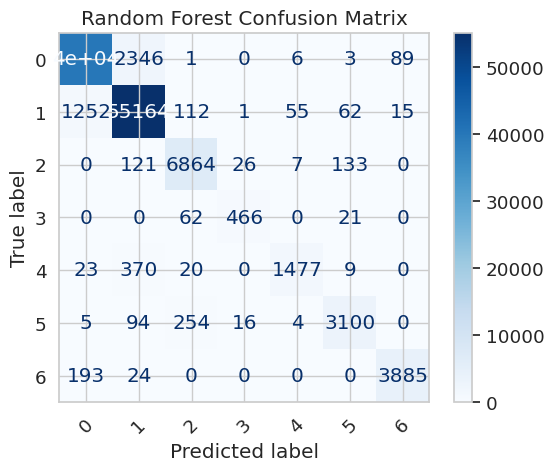

In [5]:
# Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

print("📊 Random Forest Report")
print(classification_report(y_test, y_pred_rf))

# Confusion matrix
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_rf)).plot(cmap="Blues", xticks_rotation=45)
plt.title("Random Forest Confusion Matrix")
plt.show()


##  Feature Importance (Random Forest)


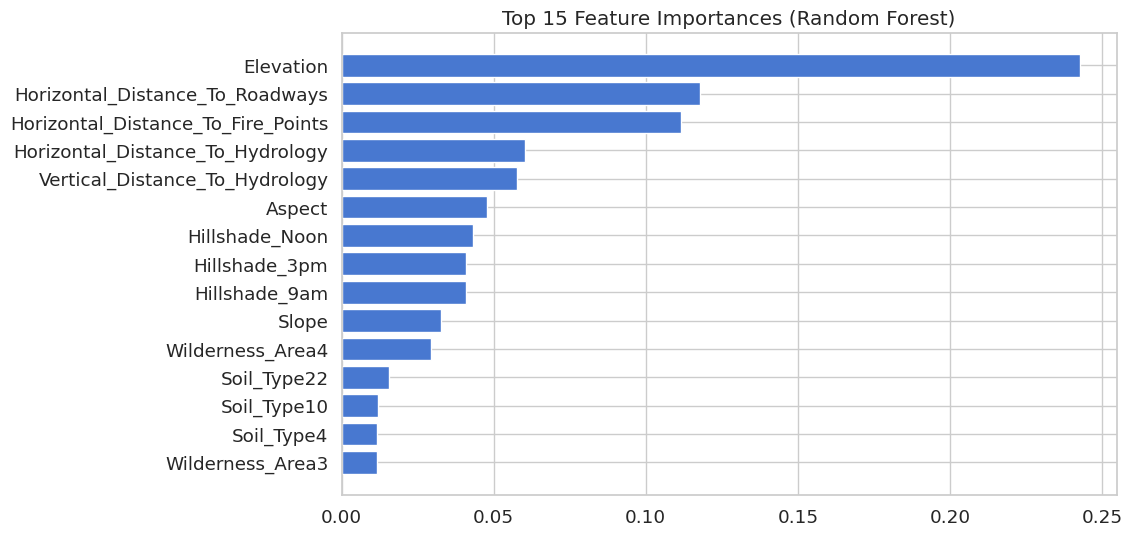

In [10]:
importances = rf.feature_importances_
indices = np.argsort(importances)[-15:]  # Top 15 features

plt.figure(figsize=(10,6))
plt.barh(range(len(indices)), importances[indices], align="center")
plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
plt.title("Top 15 Feature Importances (Random Forest)")
plt.show()


##  Model 2: XGBoost Classifier
Train and evaluate an XGBoost model.


📊 XGBoost Classification Report
              precision    recall  f1-score   support

           1       0.86      0.84      0.85     42368
           2       0.87      0.90      0.88     56661
           3       0.89      0.91      0.90      7151
           4       0.88      0.86      0.87       549
           5       0.89      0.61      0.72      1899
           6       0.85      0.80      0.82      3473
           7       0.95      0.91      0.93      4102

    accuracy                           0.87    116203
   macro avg       0.88      0.83      0.85    116203
weighted avg       0.87      0.87      0.87    116203



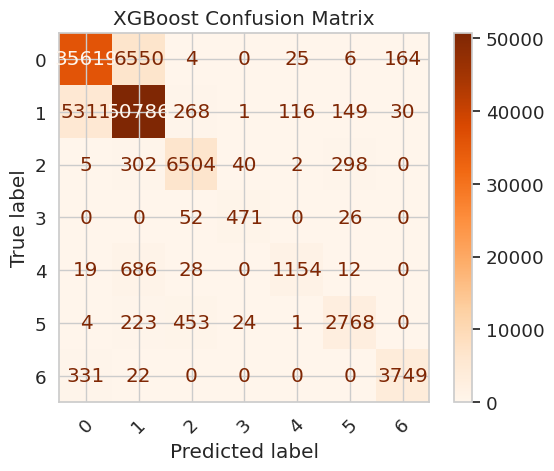

In [12]:
# =========================
# XGBoost Classifier (Fixed for 1–7 labels)
# =========================

from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Shift labels for XGBoost (0–6 instead of 1–7)
y_train_xgb = y_train - 1
y_test_xgb = y_test - 1

# Define and train model
xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric="mlogloss",
    random_state=42,
    n_jobs=-1
)
xgb.fit(X_train, y_train_xgb)

# Predictions (shift back to 1–7 for evaluation)
y_pred_xgb = xgb.predict(X_test) + 1

# Evaluation
print("📊 XGBoost Classification Report")
print(classification_report(y_test, y_pred_xgb))

# Confusion Matrix
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_xgb)).plot(cmap="Oranges", xticks_rotation=45)
plt.title("XGBoost Confusion Matrix")
plt.show()



##  Model Comparison
Compare accuracy of Random Forest vs. XGBoost.


Random Forest Accuracy: 0.9541836269287368
XGBoost Accuracy: 0.8696074972246843


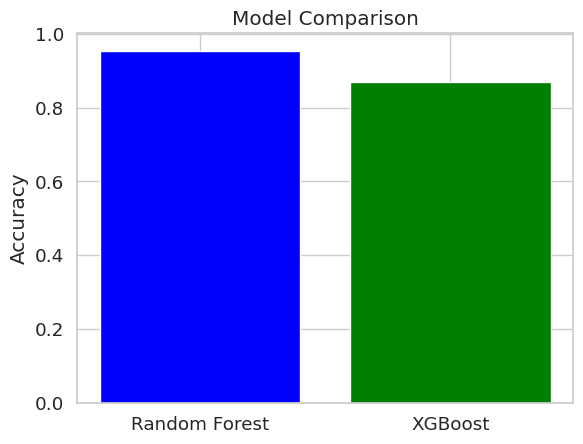

In [13]:
from sklearn.metrics import accuracy_score

acc_rf = accuracy_score(y_test, y_pred_rf)
acc_xgb = accuracy_score(y_test, y_pred_xgb)

print("Random Forest Accuracy:", acc_rf)
print("XGBoost Accuracy:", acc_xgb)

plt.bar(["Random Forest", "XGBoost"], [acc_rf, acc_xgb], color=["blue", "green"])
plt.ylabel("Accuracy")
plt.title("Model Comparison")
plt.show()


## Hyperparameter Tuning (Bonus)
Perform grid search tuning for XGBoost to improve performance.


In [ ]:
# =========================
# Hyperparameter Tuning for XGBoost (Fixed)
# =========================

from sklearn.model_selection import GridSearchCV

# Shift labels for XGBoost (expects 0–6 instead of 1–7)
y_train_xgb = y_train - 1
y_test_xgb = y_test - 1

# Base model
xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric="mlogloss",
    random_state=42,
    n_jobs=-1
)

# Parameter grid
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [5, 7],
    "learning_rate": [0.05, 0.1],
    "subsample": [0.8, 1.0]
}

# GridSearchCV
grid = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring="accuracy",
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Fit on shifted labels
grid.fit(X_train, y_train_xgb)

print("✅ Best Parameters:", grid.best_params_)

# Best model
best_xgb = grid.best_estimator_

# Predictions (shift back to 1–7 for evaluation)
y_pred_best_xgb = best_xgb.predict(X_test) + 1

print("\n📊 Best XGBoost Classification Report")
print(classification_report(y_test, y_pred_best_xgb))

# Confusion Matrix
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_best_xgb)).plot(cmap="Purples", xticks_rotation=45)
plt.title("Best XGBoost Confusion Matrix")
plt.show()


Fitting 3 folds for each of 16 candidates, totalling 48 fits
